In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import albumentations as A
from albumentations.pytorch import ToTensorV2
import io
from tqdm import tqdm

In [2]:
train_files = glob.glob("/kaggle/input/tpu-getting-started/*/train/*.tfrec")
val_files = glob.glob("/kaggle/input/tpu-getting-started/*/val/*.tfrec")
test_files = glob.glob("/kaggle/input/tpu-getting-started/*/test/*.tfrec")

In [3]:

train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
def _parse_image_function(example_proto):
     return tf.io.parse_single_example(example_proto, train_feature_description)

In [5]:
def data_from_tfrec(files , test = False):
    
    _ids = []
    _class = []
    _images = []
    for i in files:
          train_image_dataset = tf.data.TFRecordDataset(i)
    train_image_dataset = train_image_dataset.map(_parse_image_function)
    ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
    _ids = _ids + ids
    if(not test):
        classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
        _class = _class + classes
    images = [np.array(Image.open(io.BytesIO(image_features['image'].numpy()))) 
              for image_features in train_image_dataset]
    #print(type(images[0]))
    _images = _images + images
    
    return _ids , _class , _images

In [6]:
train_ids , train_classes,train_images = data_from_tfrec(train_files)
val_ids , val_classes,val_images = data_from_tfrec(val_files)
test_ids , _ ,val_images = data_from_tfrec(val_files , test = True)


2022-12-25 08:05:37.218744: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-25 08:05:37.773003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
class flowerDataset(Dataset):
    def __init__(self , ids ,classes,images, transform = None):
        self.id = ids
        self.classses = classes
        self.images = images
        self.transform = transform 
        
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, index):
        image = self.images[index]#np.array(Image.open(io.BytesIO(self.images[index])))
        label = self.classses[index]
        
        if self.transform is not None:
            #image = np.abs(image -image.max(0))/255 #rescale to be between 0 and 1
            image = self.transform(image = image)
        
        return image["image"], label 

In [19]:
image_height = 256
image_width = 256
train_transform = A.Compose(
        [
            A.Resize(height= image_height , width= image_width , always_apply= True),
            A.CenterCrop(224, 224),
            A.Normalize(
               mean=[0.48235, 0.45882, 0.40784],
               std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098],
           ),
            ToTensorV2()
        ]
    )

val_transform = A.Compose(
        [
            A.Resize(height= image_height , width= image_width),
            A.CenterCrop(224, 224),
            A.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098],
            ),
            ToTensorV2()
        ]
    )

In [20]:
train_dataset = flowerDataset(train_ids , train_classes , train_images ,
                              transform = train_transform)
val_dataset = flowerDataset(val_ids, val_classes, val_images
                            , transform = val_transform)

In [67]:
print(f"number of classes = {len(set(train_classes))}, ranges from {np.array(train_classes).min()} to {np.array(train_classes).max()}")

number of classes = 93, ranges from 0 to 103


In [22]:
batch_size = 16
train_loader = DataLoader(train_dataset , batch_size= batch_size,
                          shuffle= True , pin_memory= True )
val_loader = DataLoader(val_dataset , batch_size= batch_size ,
                         shuffle= True , pin_memory= True )

In [84]:
data , label = next(iter(train_loader))
print(f" data shape: {data.shape} and labels : {label.shape}") 

 data shape: torch.Size([16, 3, 224, 224]) and labels : torch.Size([16])


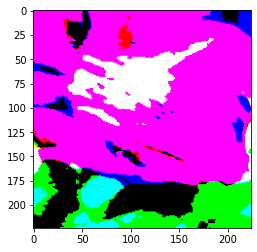

In [25]:
img = data[0]
img = np.transpose(img , (1, 2, 0))
plt.imshow(img)
plt.show()

## implementing vgg16 from scratch as the model 

- paper of VGG architectur https://arxiv.org/abs/1409.1556
- [batch size effect paper](https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=In%20practical%20terms%2C%20to%20determine,advantage%20of%20the%20GPUs%20processing.)

In [76]:
class vgg16(nn.Module):
    def __init__(self):
        super(vgg16, self).__init__()
        
        self.conv1 = nn.Sequential( 
        nn.Conv2d(3 , 64, kernel_size = 3 , stride = 1, padding = 1),
            nn.Conv2d(64 , 64, 3 ,padding= (1,1) , stride = (1,1)),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential( 
        nn.Conv2d(64 , 128, 3 ,padding= (1,1) , stride = (1,1)),
            nn.Conv2d(128 , 128, 3 ,padding= (1,1) , stride = (1,1)),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential( 
        nn.Conv2d(128 , 256, 3 ,padding= (1,1) , stride = (1,1)),
            nn.Conv2d(256 , 256, 3 ,padding= (1,1) , stride = (1,1)),
             nn.Conv2d(256 , 256, 3 ,padding= (1,1) , stride = (1,1)),
            nn.ReLU()
        )
            
        self.conv4 = nn.Sequential( 
        nn.Conv2d(256 , 512, 3 ,padding= (1,1) , stride = (1,1)),
            nn.Conv2d(512 , 512, 3 ,padding= (1,1) , stride = (1,1)),
             nn.Conv2d(512 , 512, 3 ,padding= (1,1) , stride = (1,1)),
            nn.ReLU()
        )
        
        self.conv5 = nn.Sequential( 
        nn.Conv2d(512 , 512, 3 ,padding= (1,1) , stride = (1,1)),
            nn.Conv2d(512 , 512, 3 ,padding= (1,1) , stride = (1,1)),
             nn.Conv2d(512 , 512, 3 ,padding= (1,1) , stride = (1,1)),
            nn.ReLU()
        )
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(512*7*7, 4069)
        self.fc2 = nn.Linear(4069, 4069)
        self.fc3 = nn.Linear(4069, 104)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.pool(x)
        #print(x.shape)
        #print(x.reshape(x.shape[0], -1).shape)
        x = self.fc1(x.reshape(x.shape[0], -1))
        x = self.fc2(x)
        x = self.fc3(x)
        
        
        
        return x    

In [77]:
lr = 10e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vgg16()
model.to(device)
optimizer = torch.optim.Adam(model.parameters() , lr = lr)
loss_fn = nn.CrossEntropyLoss()
def train( model , dataloader , optimizer , loss_fn ):
        qbar = tqdm(train_loader)
    
        for idx , (data, labels) in enumerate(qbar):
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(data)
            loss = loss_fn(preds , labels)
            #backward
            loss.backward()
            optimizer.step()
            qbar.set_postfix(loss = loss.item())
    
    

In [ ]:
num_epochs = 5
for i in range(num_epochs):
    train(model, qbar, optimizer, loss_fn)

In [91]:
torch.softmax(torch.rand(16, 104)  , dim = 1).shape

torch.Size([16, 104])

In [92]:
def test(model, val_loader, device):
    correct = 0
    size = 0
    
    for idx , (data,labels) in enumerate(val_loader):
        data = data.to(device)
        labels = labels.to(device)
        model.eval()
        with torch.no_grad():
            preds = torch.softmax(model(x) , dim = 1)
            preds = torch.argmax(preds, dim = 0 )
            correct += (preds == labels).float().sum()
            size += len(preds)
            print(f" batch {idx}, accuracy = {correct/size: 0.3f}")
    print(f" total accuracy = {correct/size: 0.3f}")
    

## using lr schedular, weight decay and momentum

- will add later

## using regulization, and batch normalization
- will add later